In [1]:
from __future__ import unicode_literals
import re
import os
import codecs
import json
import csv
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
import numpy as np
nlp=spacy.load('en')

In [2]:
intent_dict_AskUbuntu = {
    "make-update":0, 
    "setup-printer":1, 
    "shutdown-computer":2, 
    "software-recommendation":3, 
    "none":4}
intent_dict_Chatbot = {"DepartureTime":0, "FindConnection":1}
intent_dict_WebApplications = {"Download Video":0, "Change Password":1, "None":2, "Export Data":3, "Sync Accounts":4,
                  "Filter Spam":5, "Find Alternative":6, "Delete Account":7}

benchmark_dataset = 'AskUbuntu' #choose from 'AskUbuntu', 'Chatbot' or 'WebApplications'

In [3]:
def read_CSV_datafile(filename):    
    X = []
    y = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            X.append(row[0])
            if benchmark_dataset == 'AskUbuntu':
                y.append(intent_dict_AskUbuntu[row[1]])
            elif benchmark_dataset == 'Chatbot':
                y.append(intent_dict_Chatbot[row[1]])
            else:
                y.append(intent_dict_WebApplications[row[1]])           
    return X,y

In [4]:
X_train_raw, y_train_raw = read_CSV_datafile(filename = 'datasets/test-train-split/recast/AskUbuntu.csv')
X_test_raw, y_test_raw = read_CSV_datafile(filename = 'datasets/test-train-split/recast/AskUbuntu.csv')

In [5]:
print("Training data samples: \n",X_train_raw[-5:-1], "\n\n")
print("Class Labels: \n", y_train_raw[-5:-1], "\n\n")
print("Size of Training Data: {}".format(len(X_train_raw)))

Training data samples: 
 ['How to Install Brother DCP-8110DN Laser Printer on Ubuntu?', 'How to Install a Canon MF8040Cn Printer on Ubuntu 12.04', 'How Do I Install Canon MF8000C Printer in Ubuntu 15.10?', 'How to install Canon LBP330 in Lts 16.04'] 


Class Labels: 
 [1, 1, 1, 1] 


Size of Training Data: 109


In [6]:
def tokenize(doc):
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        tokens.append(token.text)
    return tokens

In [7]:
def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

In [8]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens

def semhash_corpus(corpus):
    new_corpus = []
    for sentence in corpus:
        sentence = preprocess(sentence)
        tokens = semhash_tokenizer(sentence)
        new_corpus.append(" ".join(map(str,tokens)))
    return new_corpus

X_train_raw = semhash_corpus(X_train_raw)
X_test_raw = semhash_corpus(X_test_raw)

X_train_raw[:5]

['#so sof oft ftw twa war are re# #us use se# #vi vie iew ew# #ep epu pub ub# #do doc ocu cum ume men ent nt# #?#',
 '#PD PDF DF# #Vi Vie iew ewe wer er# #re rec eco com omm mme men end nd# #?#',
 '#id ide de# #av ava vai ail ila lab abl ble le# #Ub Ubu bun unt ntu tu# #?#',
 '#go goo ood od# #Mi Min ind nd# #ma map app ppi pin ing ng# #so sof oft ftw twa war are re# #?#',
 '#so sof oft ftw twa war are re# #re rea ead ad# #qr qr# #co cod ode de# #?#']

In [9]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = CountVectorizer(ngram_range=(2,4),analyzer='char')
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [10]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [11]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    print(pred)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time, clf

In [12]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.savefig("./results_AskUbuntu.png", format="png")
    plt.show()

In [13]:
def data_for_training():
    vectorizer, feature_names = get_vectorizer(X_train_raw, preprocessor=preprocess, tokenizer=tokenize)
    
    X_train_no_HD = vectorizer.transform(X_train_raw).toarray()
    X_test_no_HD = vectorizer.transform(X_test_raw).toarray()
            
    return X_train_no_HD, y_train_raw, X_test_no_HD, y_test_raw, feature_names

X_train, y_train, X_test, y_test, feature_names = data_for_training()

In [14]:
#     X_train, y_train, X_test, y_test, feature_names = data_for_training()
def ngram_encode(str_test, HD_aphabet, aphabet, n_size): # method for mapping n-gram statistics of a word to an N-dimensional HD vector
    HD_ngram = np.zeros(HD_aphabet.shape[1]) # will store n-gram statistics mapped to HD vector
    full_str = '#' + str_test + '#' # include extra symbols to the string
        
    for il, l in enumerate(full_str[:-(n_size-1)]): # loops through all n-grams
        hdgram = HD_aphabet[aphabet.find(full_str[il]), :] # picks HD vector for the first symbol in the current n-gram
        for ng in range(1, n_size): #loops through the rest of symbols in the current n-gram
            hdgram = hdgram * np.roll(HD_aphabet[aphabet.find(full_str[il+ng]), :], ng) # two operations simultaneously; binding via elementvise multiplication; rotation via cyclic shift
            
        HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram
    
    HD_ngram_norm = np.sqrt(HD_aphabet.shape[1]) * (HD_ngram/ np.linalg.norm(HD_ngram) )  # normalizes HD-vector so that its norm equals sqrt(N)       
    return HD_ngram_norm # output normalized HD mapping



N = 1000 # set the desired dimensionality of HD vectors
n_size=3 # n-gram size
aphabet = 'abcdefghijklmnopqrstuvwxyz#' #fix the alphabet. Note, we assume that capital letters are not in use 
np.random.seed(1) # for reproducibility
HD_aphabet = 2 * (np.random.randn(len(aphabet), N) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet

# str='High like a basketball jump' # example string to represent using n-grams

# print(len(ngram_encode(str, HD_aphabet, aphabet, n_size))) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
print(X_train_raw[:1])

for i in range(len(X_train_raw)):
     X_train_raw[i] = ngram_encode(X_train_raw[i], HD_aphabet, aphabet, n_size) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
print(X_train_raw[:5])
for i in range(len(X_test_raw)):
    X_test_raw[i] = ngram_encode(X_test_raw[i], HD_aphabet, aphabet, n_size)
print(X_test_raw[:5])

X_train, y_train, X_test, y_test = X_train_raw, y_train_raw, X_test_raw, y_test_raw
print(X_train[:5])


['#so sof oft ftw twa war are re# #us use se# #vi vie iew ew# #ep epu pub ub# #do doc ocu cum ume men ent nt# #?#']
[array([ 0.0712008 ,  1.49521685, -2.06482327,  0.64080722,  0.35600401,
        0.0712008 ,  0.0712008 ,  0.0712008 ,  0.64080722, -0.92561043,
        0.35600401, -0.92561043, -0.78320883, -1.21041364, -0.0712008 ,
       -0.64080722, -0.21360241,  0.21360241,  0.49840562,  0.35600401,
        0.21360241,  0.0712008 ,  0.49840562, -2.34962648,  1.63761846,
       -1.06801204,  0.92561043, -0.21360241,  0.92561043,  0.92561043,
        0.0712008 ,  0.35600401,  0.35600401,  0.92561043, -1.35281525,
       -1.78002006,  0.78320883,  0.49840562,  2.06482327, -1.35281525,
        0.21360241, -1.06801204, -1.06801204,  0.78320883,  0.64080722,
        1.06801204, -1.21041364, -1.21041364,  0.64080722,  1.35281525,
       -0.92561043, -2.06482327,  0.21360241, -0.0712008 ,  0.21360241,
        0.0712008 , -0.49840562,  0.0712008 ,  1.35281525,  1.78002006,
       -1.21041364,

Evaluating Split 0
Train Size: 109
Test Size: 109
Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.023s
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 4 3 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1]
test time:  0.066s
accuracy:   1.000
dimensionality: 1000
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            make-update       1.00      1.00      1.00        37
          setup-printer       1.00      1.00      1.00        13
      shutdown-computer       1.00      1.00      1.00        14
software-recommendation       1.00      1.00      1.00        40
   

C:\Users\Mitsuo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Mitsuo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mitsuo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Mitsuo\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated

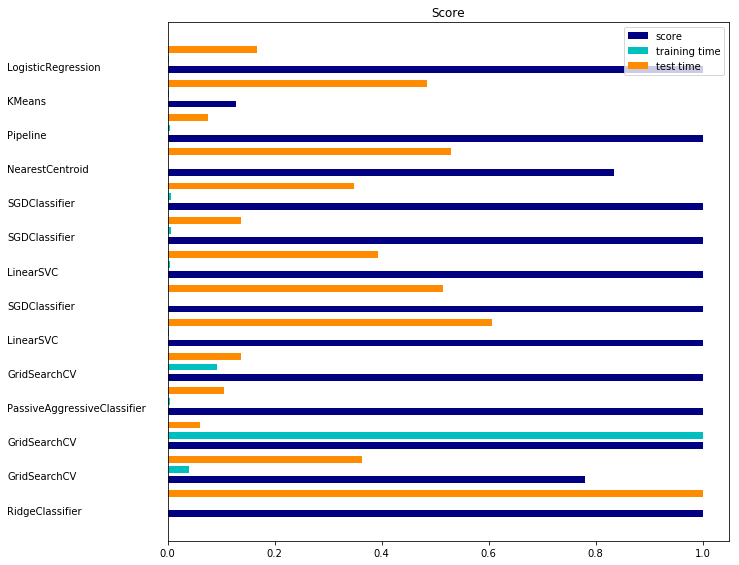

In [15]:
import matplotlib.pyplot as plt
for i_s, split in enumerate(range(1)):
    print("Evaluating Split {}".format(i_s))
#     X_train, y_train, X_test, y_test, feature_names = data_for_training()
    target_names = ["make-update", "setup-printer", "shutdown-computer","software-recommendation", "none"]
    #target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts", "Filter Spam", "Find Alternative", "Delete Account"]
    print("Train Size: {}\nTest Size: {}".format(np.shape(X_train)[0], np.shape(X_test)[0]))
    results = []
    #alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    parameters_mlp={'hidden_layer_sizes':[(100,50), (300, 100),(300,200,100)]}
    parameters_RF={ "n_estimators" : [50,60,70],
           "min_samples_leaf" : [1, 11]}
    k_range = list(range(3,7))
    parameters_knn = {'n_neighbors':k_range}
    knn=KNeighborsClassifier(n_neighbors=5)
    for clf, name in [  
            (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            (GridSearchCV(knn,parameters_knn, cv=5),"gridsearchknn"),
            #(Perceptron(n_iter=50), "Perceptron"),
            (GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=5),"gridsearchmlp"),
           # (MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", max_iter=300), "MLP"),
            #(MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="logistic", max_iter=500), "MLP"),
           # (MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="tanh", max_iter=500), "MLP"),
            (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
           # (KNeighborsClassifier(n_neighbors=1), "kNN"),
           # (KNeighborsClassifier(n_neighbors=3), "kNN"),
           # (KNeighborsClassifier(n_neighbors=5), "kNN"),
            #(KNeighborsClassifier(n_neighbors=10), "kNN"),
            (GridSearchCV(RandomForestClassifier(n_estimators=10),parameters_RF, cv=5),"gridsearchRF")
            #(RandomForestClassifier(n_estimators=10), "Random forest"),
            #(RandomForestClassifier(n_estimators=50), "Random forest")
    ]:
           
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))
       # print('parameters')
       # print(clf.grid_scores_[0])
        #print('CV Validation Score')
       # print(clf.grid_scores_[0].cv_validation_scores)
       # print('Mean Validation Score')
       # print(clf.grid_scores_[0].mean_validation_score)
       # grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
       # print(grid_mean_scores)
       # plt.plot(k_range, grid_mean_scores)
       # plt.xlabel('Value of K for KNN')
       # plt.ylabel('Cross-Validated Accuracy')

    #parameters_Linearsvc = [{'C': [1, 10], 'gamma': [0.1,1.0]}]
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        #grid=(GridSearchCV(LinearSVC,parameters_Linearsvc, cv=10),"gridsearchSVC")
        #results.append(benchmark(LinearSVC(penalty=penalty), X_train, y_train, X_test, y_test, target_names,
                                # feature_names=feature_names))
        results.append(benchmark(LinearSVC(penalty=penalty, dual=False,tol=1e-3),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid(),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train sparse Naive Bayes classifiers
    #print('=' * 80)
    #print("Naive Bayes")
    #results.append(benchmark(MultinomialNB(alpha=.01),
    #                         X_train, y_train, X_test, y_test, target_names,
    #                         feature_names=feature_names))
    #results.append(benchmark(BernoulliNB(alpha=.01),
    #                         X_train, y_train, X_test, y_test, target_names,
    #                         feature_names=feature_names))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
    results.append(benchmark(Pipeline([
                                  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                                                  tol=1e-3))),
                                  ('classification', LinearSVC(penalty="l2"))]),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
   # print(grid.grid_scores_)
   #KMeans clustering algorithm 
    print('=' * 80)
    print("KMeans")
    results.append(benchmark(KMeans(n_clusters=2, init='k-means++', max_iter=300,
                verbose=0, random_state=0, tol=1e-4),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
   
    
    print('=' * 80)
    print("LogisticRegression")
    #kfold = model_selection.KFold(n_splits=2, random_state=0)
    #model = LinearDiscriminantAnalysis()
    results.append(benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    plot_results(results)

In [16]:
target_names = ["make-update", "setup-printer", "shutdown-computer","software-recommendation", "none"]
_, _, _, _, clf = benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names)

intent = ["make-update", "setup-printer", "shutdown-computer", "software-recommendation", "none"]

________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
train time: 0.069s
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 4 3 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1]
test time:  0.034s
accuracy:   1.000
dimensionality: 1000
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            make-update       1.00      1.00      1.00        37
          setup-printer       1.00      1.00      1.00        13
      shutdown-computer       1.00      1.00      1.00        14
software-recommendation       1.00      1

In [21]:
question = "what is the best program for make 3d objects?"
print("QUESTION:", question)

X_train_raw = semhash_corpus([question])
print("SEMHASH:", X_train_raw)

X_train_raw = ngram_encode(X_train_raw[0], HD_aphabet, aphabet, n_size)
p = clf.predict([X_train_raw])[0]
print("INTENT: ", intent[p])

QUESTION: what is the best program for make 3d objects?
SEMHASH: ['#go goo ood od# #pr pro rog ogr gra ram am# #3d 3d# #ob obj bje jec ect ct# #?#']
INTENT:  software-recommendation
